<a href="https://colab.research.google.com/github/isarps/ai-python/blob/main/SerieTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [19]:
# Carrega dados
url = 'https://raw.githubusercontent.com/isarps/ai-python/main/coffee.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


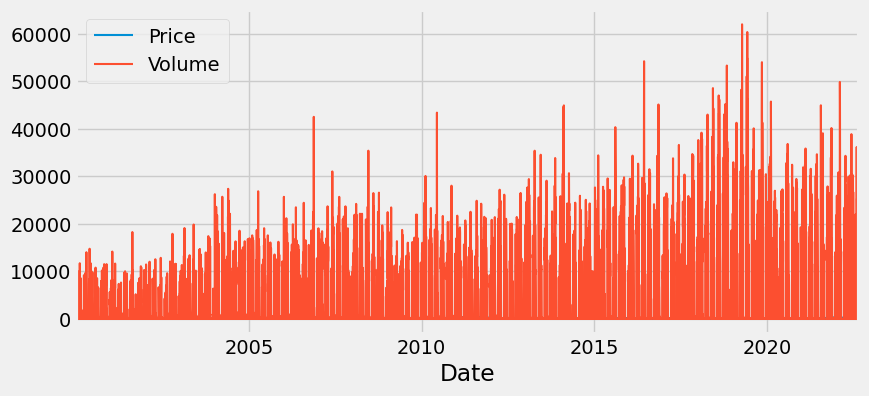

In [15]:
# Tratamento de dados
# Converte data de string para datetime e transforma em índice
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
# Seto o índice
data = data.set_index('Date')
# Defino a frequência (Diaria). Caso falte registro, cria um novo e preenche as demais colunas com 0.0
data = data.asfreq('D', fill_value=0.0)
# Ordena pela data
data = data.sort_index()

# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
data['Close'].plot(ax=ax, label='Price')
data['Volume'].plot(ax=ax, label='Volume')
ax.legend();

In [16]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [17]:
# Código para verificar se não existem "buracos" nos dados
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 0 --- 5545  (n=5546)
Test dates  : 5546 --- 5745  (n=200)


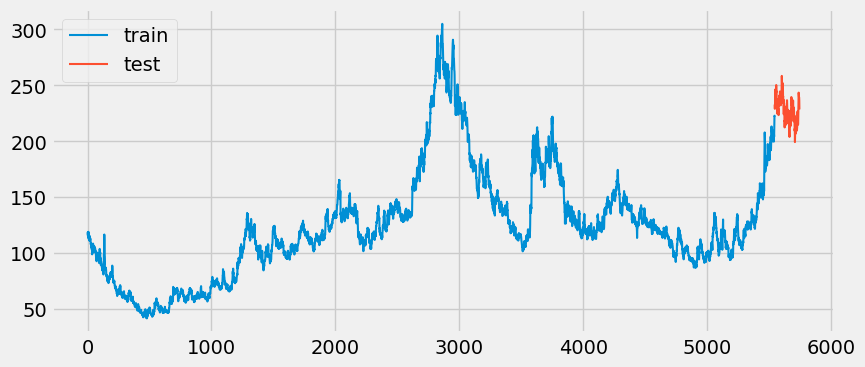

In [24]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 200
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['Close'].plot(ax=ax, label='train')
data_test['Close'].plot(ax=ax, label='test')
ax.legend();

In [54]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 180
             )

forecaster.fit(y=data_train['Close']) #, exog=data_train['Volume'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: N

In [56]:
# Faz predição no conjunto de teste
steps = 200
predictions = forecaster.predict(steps=steps) #, exog=data_test['Volume'])
predictions.head(5)

5546    221.931575
5547    221.184726
5548    219.995507
5549    220.641627
5550    220.568393
Name: pred, dtype: float64

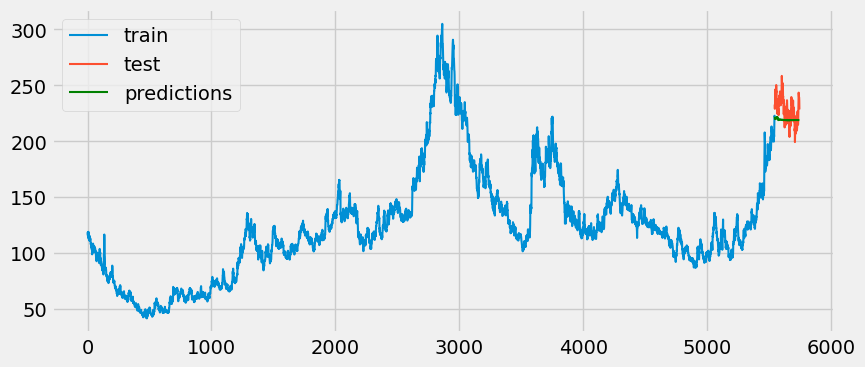

In [57]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['Close'].plot(ax=ax, label='train')
data_test['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();